In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputerS
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import chi2, mutual_info_classif

In [3]:
# Load data
data = pd.read_excel('./data/data_extended.xlsx')

print(data.head())

         SourceType                                  SourceDescription  \
0          Database                      Contains customer information   
1     System/Server                      Stores web server access logs   
2   Web Application                           Online shopping platform   
3            Device                        Records employee work hours   
4  Software/Program  Allows users to access bank accounts on mobile...   

            TargetName        TargetType  \
0           CRM System     System/Server   
1        SIEM Platform  Software/Program   
2      Payment Gateway           Service   
3       Payroll System     System/Server   
4  Core Banking System     System/Server   

                                   TargetDescription            Relationship  \
0            Customer Relationship Management system               Data Sync   
1  Security Information and Event Management plat...         Log Aggregation   
2                       Handles payment transactio

In [4]:
for col in data.columns:
    print(col)

SourceType
SourceDescription
TargetName
TargetType
TargetDescription
Relationship
AuthRequired
Encryption
EncryptionType
DataFormat
Frequency
DataIntegrity
AccessType
AccessTarget
NetworkProtocol
CommunicationChannel
CredentialStorage
Interactor
Threat


In [5]:
data = data[["SourceType", "TargetType", "AuthRequired", "Encryption", "EncryptionType", "DataFormat", "Frequency", "DataIntegrity", "AccessType",
             "AccessTarget", "NetworkProtocol", "CommunicationChannel", "CredentialStorage", "Interactor", "Threat"]]

In [6]:
data = data.replace([None, ''], pd.NA)

empty_counts = data.isna().sum()

print("Number of empty rows per col: ")
print(empty_counts)

Number of empty rows per col: 
SourceType              0
TargetType              0
AuthRequired            0
Encryption              0
EncryptionType          0
DataFormat              0
Frequency               0
DataIntegrity           0
AccessType              0
AccessTarget            0
NetworkProtocol         0
CommunicationChannel    0
CredentialStorage       0
Interactor              0
Threat                  0
dtype: int64


In [7]:
class_counts = data['Threat'].value_counts()
class_counts

Threat
Cross-Site Scripting (XSS)              507
Phishing Attacks                        506
Man-in-the-Middle (MitM) Attack         468
API Security Breach                     462
Malware Attack                          457
Malvertising                            445
SQL Injection                           427
Spear Phishing Attacks                  422
Ransomware Attack                       412
No Threat                               401
Zero-day Exploit                        394
Cryptojacking                           369
Cross-Site Request Forgery (CSRF)       209
Remote Code Execution (RCE)             204
Drive-by Download Attacks               200
Credential Stuffing                     191
Directory Traversal                     183
Distributed Denial of Service (DDoS)    176
Side-Channel Attack                     171
Password Attack                         153
Denial of Service (DoS)                  78
Name: count, dtype: int64

In [8]:
# Remove classes with fewer than X instances
valid_classes = class_counts[class_counts > 20].index
data = data[data['Threat'].isin(valid_classes)]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SourceType            6835 non-null   object
 1   TargetType            6835 non-null   object
 2   AuthRequired          6835 non-null   object
 3   Encryption            6835 non-null   object
 4   EncryptionType        6835 non-null   object
 5   DataFormat            6835 non-null   object
 6   Frequency             6835 non-null   object
 7   DataIntegrity         6835 non-null   object
 8   AccessType            6835 non-null   object
 9   AccessTarget          6835 non-null   object
 10  NetworkProtocol       6835 non-null   object
 11  CommunicationChannel  6835 non-null   object
 12  CredentialStorage     6835 non-null   object
 13  Interactor            6835 non-null   object
 14  Threat                6835 non-null   object
dtypes: object(15)
memory usage: 801.1+ KB


In [10]:
unique_values_count = data.nunique()

value_counts_per_column = {col: data[col].value_counts() for col in data.columns}

unique_values_count, value_counts_per_column


(SourceType               7
 TargetType               7
 AuthRequired             2
 Encryption               2
 EncryptionType           6
 DataFormat               8
 Frequency                5
 DataIntegrity            4
 AccessType               5
 AccessTarget             8
 NetworkProtocol          8
 CommunicationChannel     7
 CredentialStorage        7
 Interactor               7
 Threat                  21
 dtype: int64,
 {'SourceType': SourceType
  Web Application     1385
  Device              1282
  Database            1189
  Service              988
  System/Server        820
  Software/Program     773
  User                 398
  Name: count, dtype: int64,
  'TargetType': TargetType
  Service             2016
  Database            1161
  Web Application     1135
  System/Server       1113
  Software/Program     834
  Device               289
  User                 287
  Name: count, dtype: int64,
  'AuthRequired': AuthRequired
  Yes    5470
  No     1365
  Name: count, d

In [11]:
print(data.describe(include='all'))

             SourceType TargetType AuthRequired Encryption EncryptionType  \
count              6835       6835         6835       6835           6835   
unique                7          7            2          2              6   
top     Web Application    Service          Yes        Yes        TLS/SSL   
freq               1385       2016         5470       5462           1712   

       DataFormat  Frequency DataIntegrity AccessType AccessTarget  \
count        6835       6835          6835       6835         6835   
unique          8          5             4          5            8   
top          JSON  Real-Time          Hash      Write     Database   
freq         2689       3235          2197       2842         3111   

       NetworkProtocol CommunicationChannel CredentialStorage Interactor  \
count             6835                 6835              6835       6835   
unique               8                    7                 7          7   
top         HTTP/HTTPS             

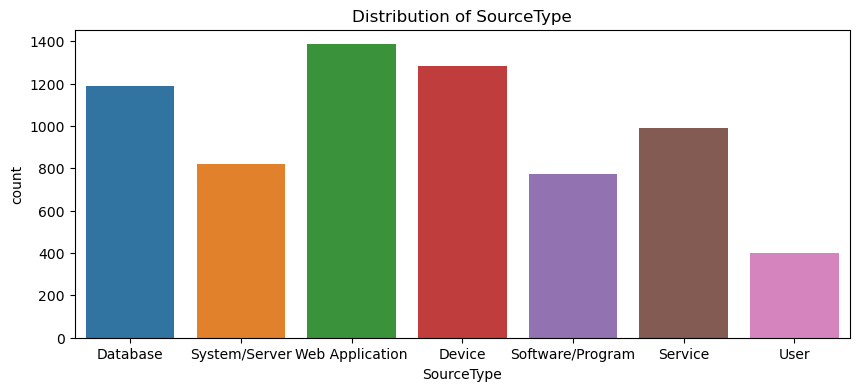

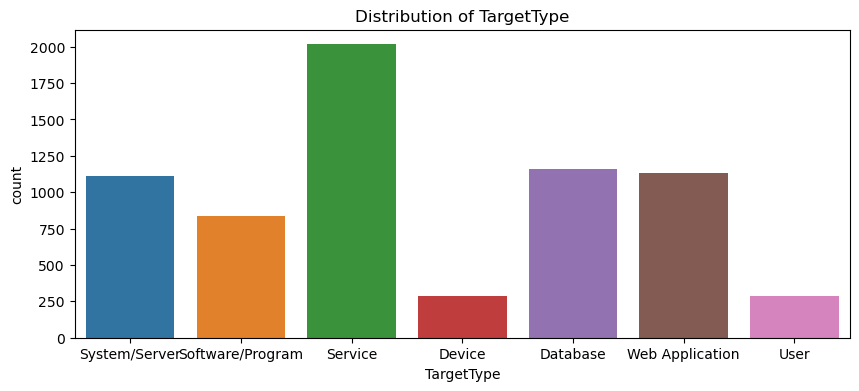

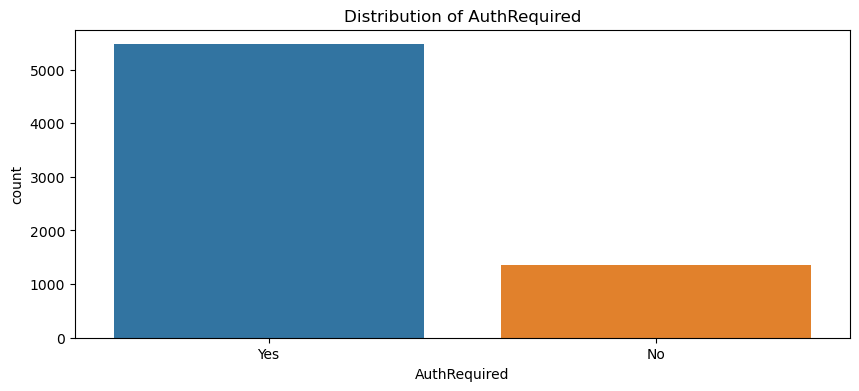

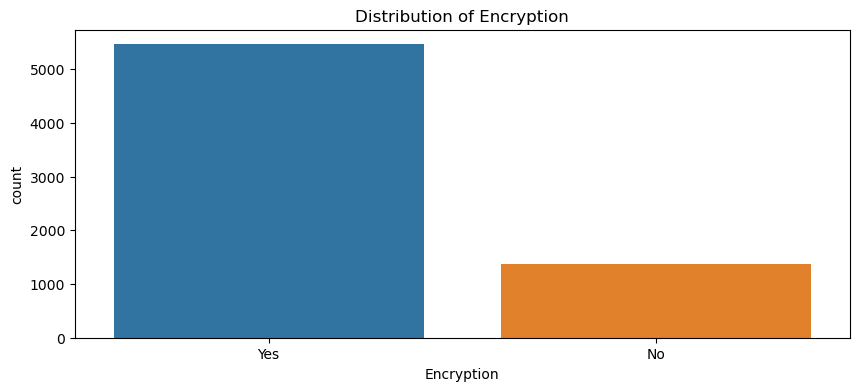

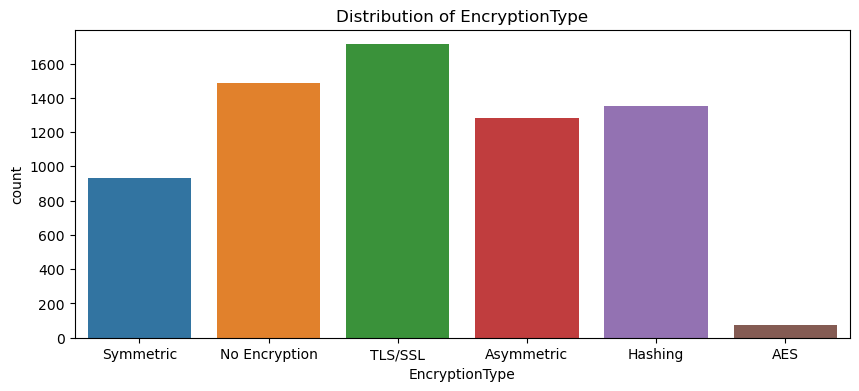

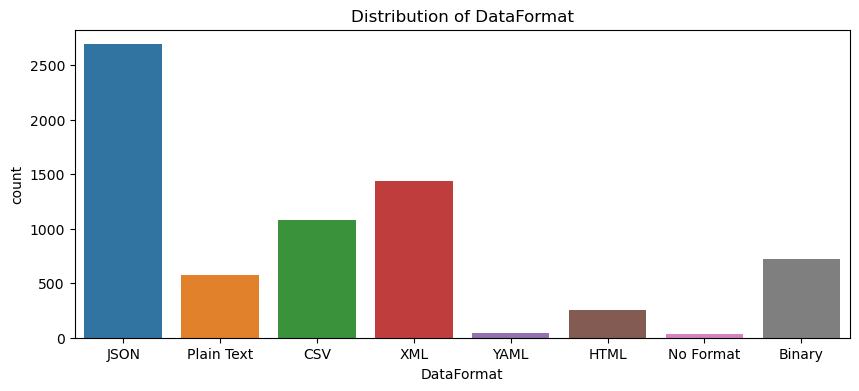

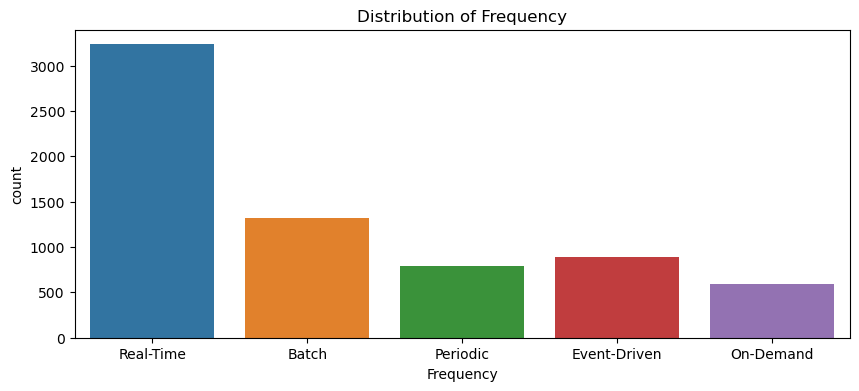

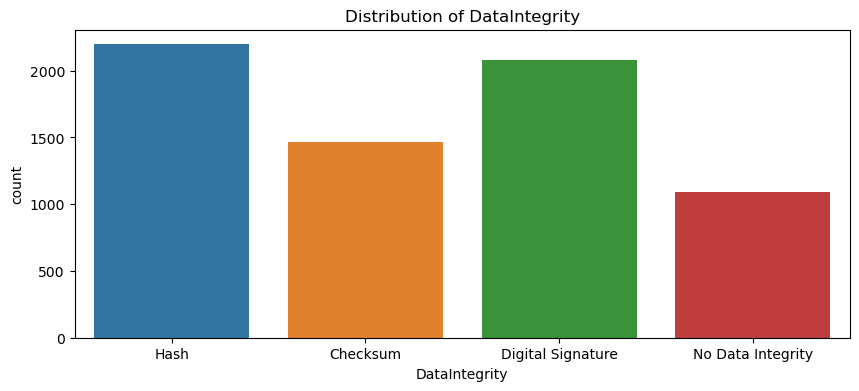

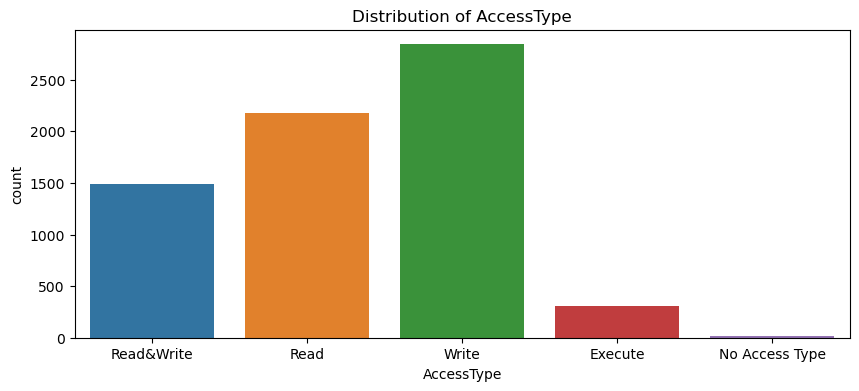

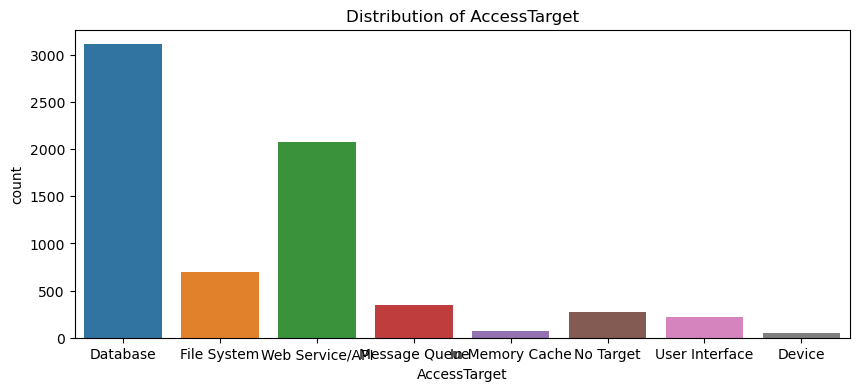

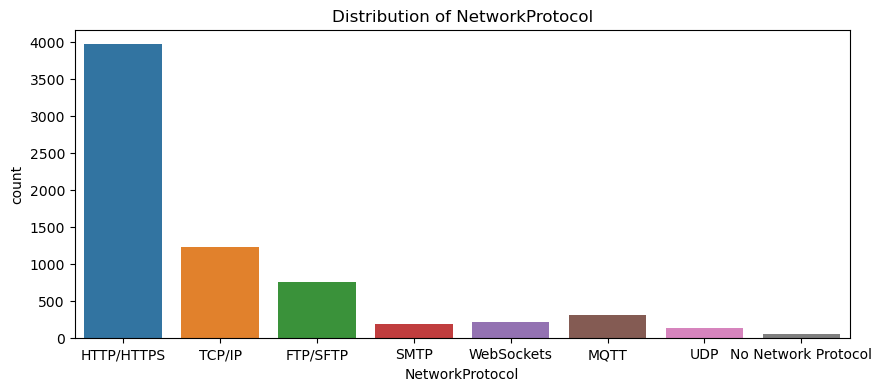

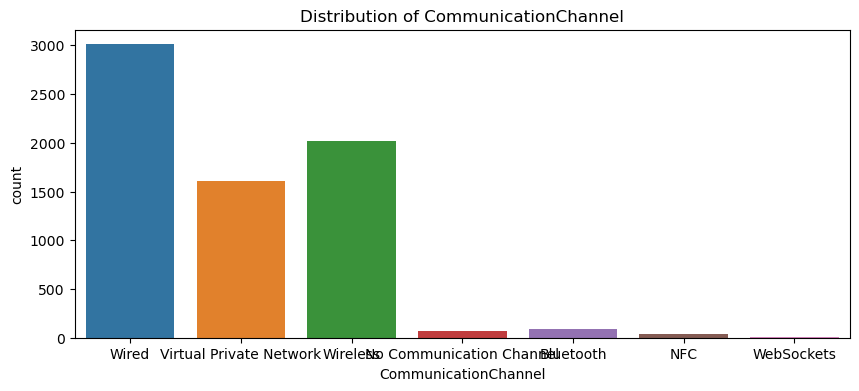

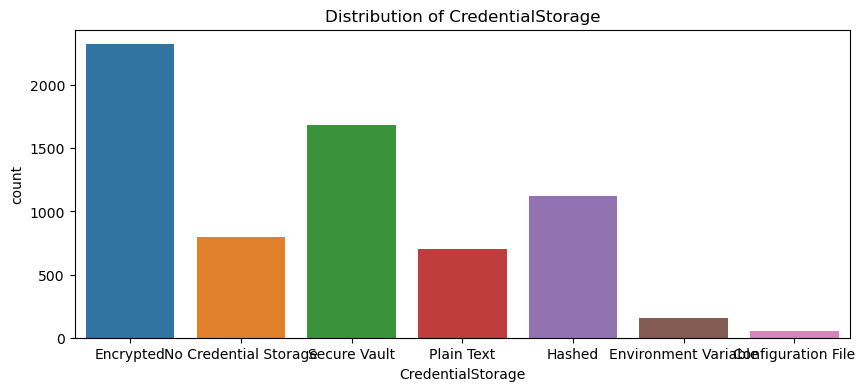

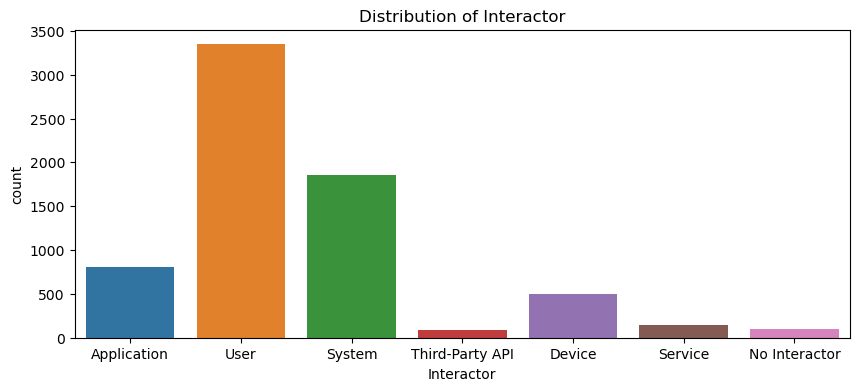

In [12]:
for column in data.drop('Threat', axis=1).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()


### Filtering data to only X threats with most occurencies

In [13]:
# # Get the top X most occurring threats
# top_X_threats = class_counts.nlargest(10).index

# # Filter the original data to only include rows with these top X threats
# filtered_data = data[data['Threat'].isin(top_X_threats)]

In [14]:
# top_X_threats

### Reduction of Complexity (Experiment)

In [15]:
# unique_values_count = data_reduced.nunique()

# value_counts_per_column = {col: data_reduced[col].value_counts() for col in data_reduced.columns}

# unique_values_count, value_counts_per_column


In [16]:
# data_reduced.info()

# Data Encoding

In [17]:
# # Separate features and target variable
# X = filtered_data.drop('Threat', axis=1)
# y = filtered_data['Threat']

In [18]:
# Separate features and target variable
X = data.drop('Threat', axis=1)
y = data['Threat']

In [19]:
# # Separate features and target variable
# X = data_reduced.drop('Threat', axis=1)
# y = data_reduced['Threat']

In [20]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_encoded_df = pd.DataFrame(y_encoded, columns=['Encoded Target'])

onehot_encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder.fit_transform(X)

X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(X.columns))

# Analysis of Data

### Correlation Analysis

In [21]:
# Define the number of top features to select
N = 25

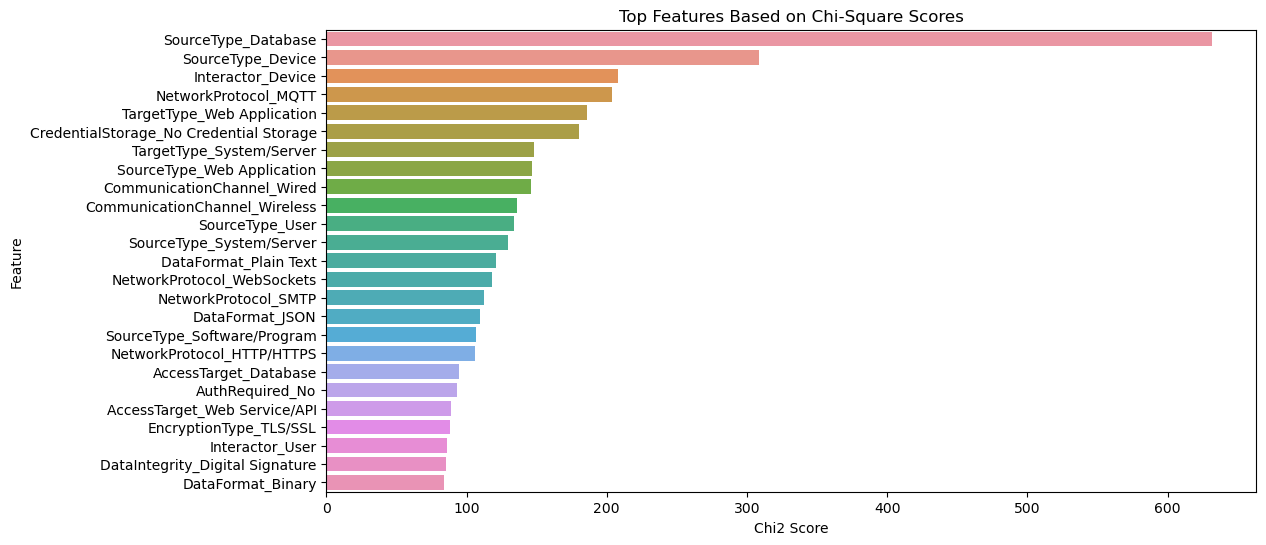

In [22]:
# Chi-Square Test
chi2_scores, p_values = chi2(X_encoded_df, y_encoded)
chi2_results = pd.DataFrame({'Feature': X_encoded_df.columns, 'Chi2 Score': chi2_scores, 'p-value': p_values})
chi2_resultsTOPN = chi2_results.sort_values(by='Chi2 Score', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_resultsTOPN)
plt.title('Top Features Based on Chi-Square Scores')
plt.show()

In [23]:
sorted_chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False)

pd.set_option('display.max_rows', None)

print(sorted_chi2_results)

pd.reset_option('display.max_rows')

                                          Feature  Chi2 Score        p-value
0                             SourceType_Database  631.824286  5.622692e-121
1                               SourceType_Device  308.765896   1.305787e-53
77                              Interactor_Device  208.115942   2.771895e-33
56                           NetworkProtocol_MQTT  203.848981   1.946285e-32
13                     TargetType_Web Application  186.028584   6.386274e-29
73        CredentialStorage_No Credential Storage  179.866115   1.031082e-27
11                       TargetType_System/Server  148.095371   1.454543e-21
6                      SourceType_Web Application  146.813696   2.556066e-21
67                     CommunicationChannel_Wired  145.868885   3.871505e-21
68                  CommunicationChannel_Wireless  135.816164   3.133920e-19
5                                 SourceType_User  134.172931   6.399052e-19
4                        SourceType_System/Server  129.371453   5.113451e-18

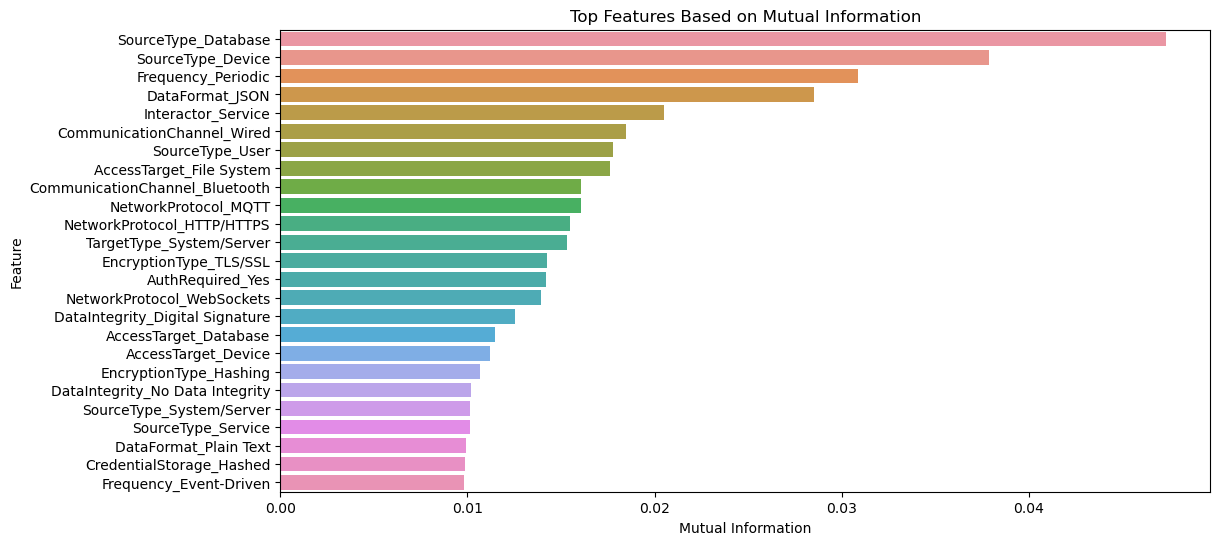

In [24]:
# Mutual Information
mutual_info = mutual_info_classif(X_encoded_df, y_encoded)
mutual_info_df = pd.DataFrame({'Feature': X_encoded_df.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mutual_info_df)
plt.title('Top Features Based on Mutual Information')
plt.show()

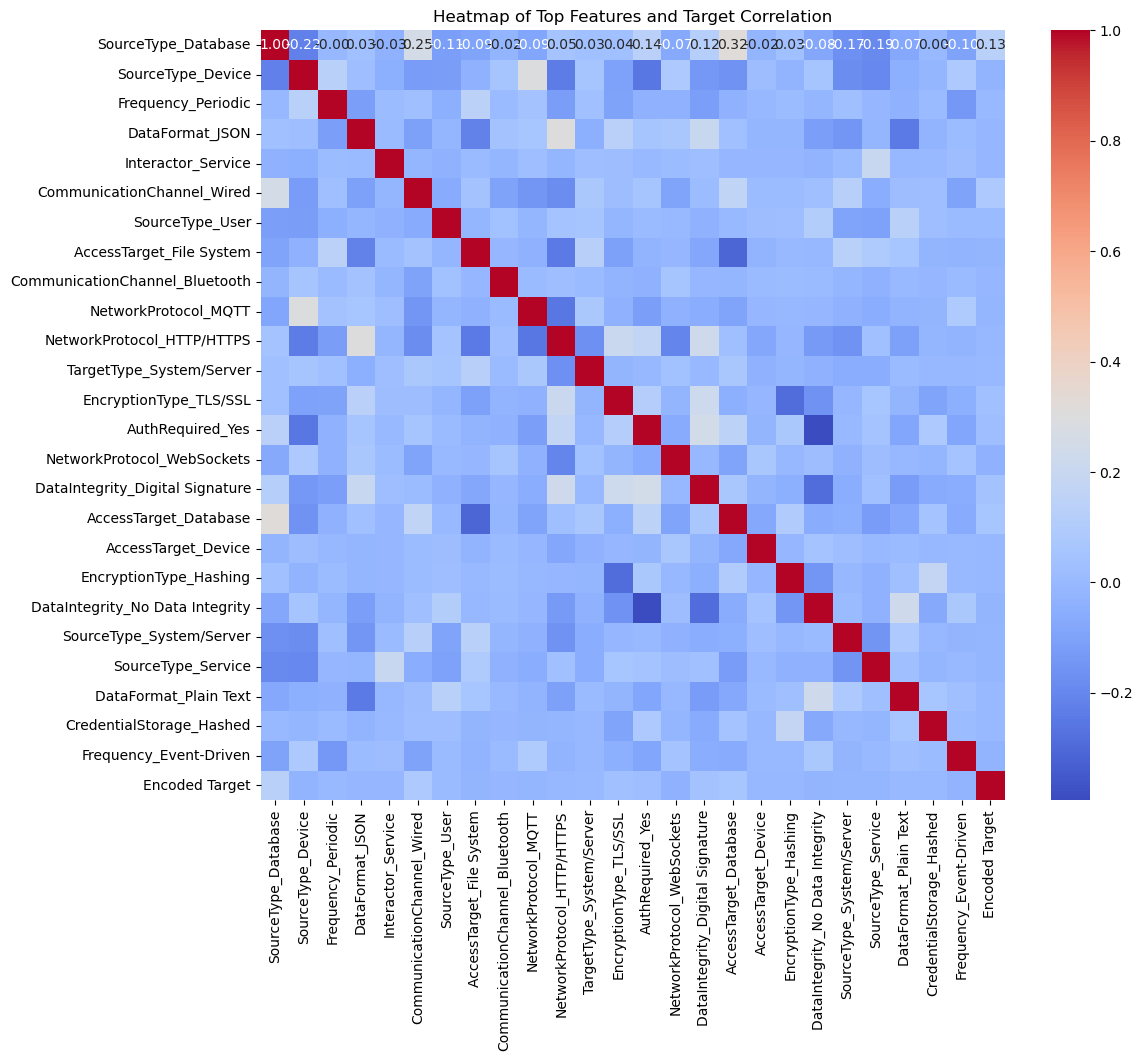

In [25]:
top_features = mutual_info_df['Feature']

top_features_df = X_encoded_df[top_features]

heatmap_data = top_features_df.join(y_encoded_df)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Top Features and Target Correlation')
plt.show()

In [26]:
correlation_matrix = heatmap_data.corr()

correlation_series = correlation_matrix.unstack()

filtered_correlations = correlation_series[correlation_series.index.get_level_values(0) != correlation_series.index.get_level_values(1)]

sorted_correlations = filtered_correlations.sort_values(ascending=False)

top_correlations = sorted_correlations.head(20)

# Display the top correlations
print(top_correlations)

AccessTarget_Database            SourceType_Database                0.317624
SourceType_Database              AccessTarget_Database              0.317624
NetworkProtocol_HTTP/HTTPS       DataFormat_JSON                    0.304150
DataFormat_JSON                  NetworkProtocol_HTTP/HTTPS         0.304150
SourceType_Device                NetworkProtocol_MQTT               0.293558
NetworkProtocol_MQTT             SourceType_Device                  0.293558
SourceType_Database              CommunicationChannel_Wired         0.249866
CommunicationChannel_Wired       SourceType_Database                0.249866
AuthRequired_Yes                 DataIntegrity_Digital Signature    0.247798
DataIntegrity_Digital Signature  AuthRequired_Yes                   0.247798
DataFormat_Plain Text            DataIntegrity_No Data Integrity    0.230165
DataIntegrity_No Data Integrity  DataFormat_Plain Text              0.230165
DataIntegrity_Digital Signature  NetworkProtocol_HTTP/HTTPS         0.229117

<Axes: >

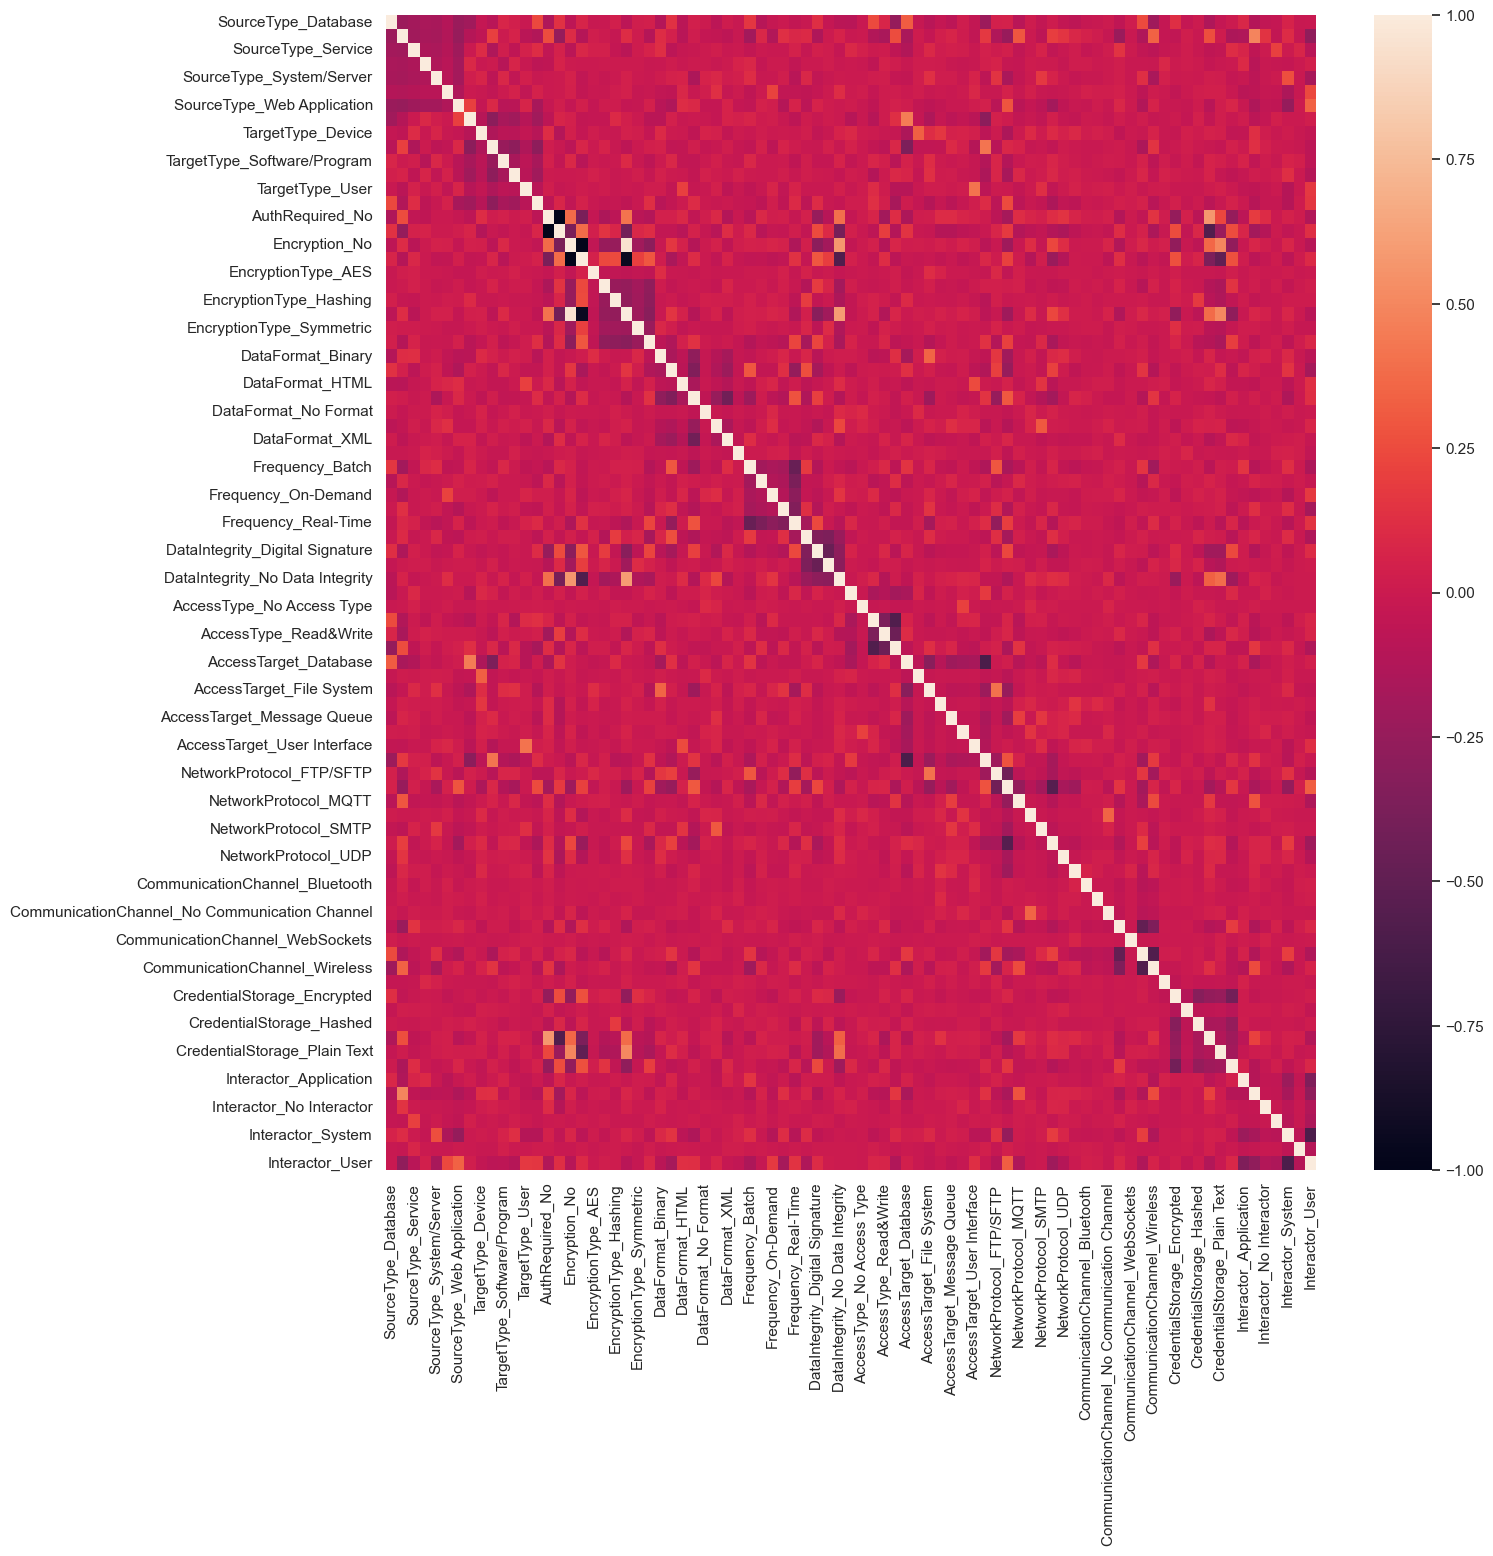

In [27]:
corrtable = pd.DataFrame(data=X_encoded_df).corr()
sns.set_theme(rc={'figure.figsize':(15,15)})
sns.heatmap(corrtable)

# Machine Learning

### Original Split

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Display the preprocessed data
print("Encoded Features:\n", X_encoded_df)
print("Encoded Target:\n", y_encoded)
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Encoded Features:
       SourceType_Database  SourceType_Device  SourceType_Service  \
0                     1.0                0.0                 0.0   
1                     0.0                0.0                 0.0   
2                     0.0                0.0                 0.0   
3                     0.0                1.0                 0.0   
4                     0.0                0.0                 0.0   
...                   ...                ...                 ...   
6830                  0.0                1.0                 0.0   
6831                  0.0                0.0                 0.0   
6832                  0.0                0.0                 0.0   
6833                  0.0                0.0                 1.0   
6834                  0.0                0.0                 0.0   

      SourceType_Software/Program  SourceType_System/Server  SourceType_User  \
0                             0.0                       0.0              0.0   
1   

### Reduced data split

In [29]:
# Select top features
top_features_chi2 = chi2_results['Feature'].tolist()
top_features_mutual_info = mutual_info_df['Feature'].tolist()

top_features = list(set(top_features_chi2 + top_features_mutual_info))

X_top_features = X_encoded_df[top_features]

X_train, X_test, y_train, y_test = train_test_split(X_top_features, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [30]:
X_top_features

,SourceType_Software/Program,EncryptionType_TLS/SSL,Encryption_Yes,NetworkProtocol_HTTP/HTTPS,SourceType_User,Encryption_No,AccessType_Read&Write,NetworkProtocol_TCP/IP,EncryptionType_AES,CommunicationChannel_Wireless,...,DataFormat_YAML,DataFormat_No Format,AccessTarget_Message Queue,EncryptionType_Asymmetric,AccessType_Execute,CredentialStorage_No Credential Storage,DataFormat_JSON,TargetType_Software/Program,CredentialStorage_Environment Variable,TargetType_System/Server
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6830,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6831,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6832,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6833,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X_encoded_df

,SourceType_Database,SourceType_Device,SourceType_Service,SourceType_Software/Program,SourceType_System/Server,SourceType_User,SourceType_Web Application,TargetType_Database,TargetType_Device,TargetType_Service,...,CredentialStorage_No Credential Storage,CredentialStorage_Plain Text,CredentialStorage_Secure Vault,Interactor_Application,Interactor_Device,Interactor_No Interactor,Interactor_Service,Interactor_System,Interactor_Third-Party API,Interactor_User
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6830,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6831,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6832,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6833,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Algorithms

### Decision Tree

In [33]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [50],
    'min_samples_split': [5],
    'min_samples_leaf': [5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(report)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5}
Accuracy: 0.10921501706484642
              precision    recall  f1-score   support

           0       0.08      0.15      0.10       139
           1       0.05      0.09      0.06        57
           2       0.03      0.03      0.03        63
           3       0.18      0.22      0.20       152
           4       0.06      0.05      0.06       111
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        55
           7       0.04      0.02      0.03        53
           8       0.06      0.05      0.06        60
           9       0.10      0.10      0.10       134
          10       0.15      0.17      0.16       137
          11       0.21      0.16      0.18       140
          12       0.16      0.14      0.15       120
          13       0.09      0.02      0.04       

### Random Forest

In [34]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.11      0.09       139
           1       0.11      0.07      0.08        57
           2       0.03      0.02      0.02        63
           3       0.17      0.22      0.19       152
           4       0.05      0.05      0.05       111
           5       0.00      0.00      0.00        23
           6       0.03      0.02      0.02        55
           7       0.04      0.02      0.03        53
           8       0.06      0.03      0.04        60
           9       0.13      0.13      0.13       134
          10       0.12      0.13      0.13       137
          11       0.19      0.25      0.22       140
          12       0.23      0.23      0.23       120
          13       0.08      0.04      0.06        46
          14       0.12      0.16      0.14       152
          15       0.09      0.09      0.09       124
          16       0.08      0.07      0.07        61
   

## SVC & Gradient Boost

In [35]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize models
models = {
    'Support Vector Classifier': SVC(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Accuracy: {accuracy_score(y_test, y_pred)}")


Support Vector Classifier Accuracy: 0.15553388590931252

Gradient Boosting Classifier Accuracy: 0.128717698683569


# Neural Network

In [36]:
source = data

In [37]:
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(source.drop('Threat', axis=1))

X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(source.drop('Threat', axis=1).columns))

onehot_encoder_target = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(source[['Threat']].astype(str))  # Ensure target is treated as string

X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(report)

Epoch 1/100


C:\Users\Dennis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0596 - loss: 3.0851 - val_accuracy: 0.0987 - val_loss: 2.9781
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0919 - loss: 2.9613 - val_accuracy: 0.0941 - val_loss: 2.9087
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1042 - loss: 2.9026 - val_accuracy: 0.1252 - val_loss: 2.8531
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1223 - loss: 2.8652 - val_accuracy: 0.1097 - val_loss: 2.8547
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1387 - loss: 2.8265 - val_accuracy: 0.1353 - val_loss: 2.8338
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1192 - loss: 2.8343 - val_accuracy: 0.1115 - val_loss: 2.8200
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1321 - loss: 2.8007 - val_accuracy: 0.1298 - val_loss: 2.8186
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1420 - loss: 2.7768 - val_accuracy: 0.1234

C:\Users\Dennis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dennis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dennis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# OneHot Encoding the target variable

In [38]:
source = data #options: data, data_reduced, filtered_data

In [41]:
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(source.drop('Threat', axis=1))

# Convert the encoded features to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(source.drop('Threat', axis=1).columns))

# One-hot encode the target variable
onehot_encoder_target = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(source[['Threat']])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, np.argmax(y_encoded, axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

y_resampled_df = pd.DataFrame(y_resampled, columns=['Threat'])

correlation_data = pd.concat([X_resampled, y_resampled_df], axis=1)

correlation_matrix = correlation_data.corr()
correlation_with_target = correlation_matrix['Threat'].drop('Threat')
top_20_correlations = correlation_with_target.abs().sort_values(ascending=False).head(20)

# Display the top 20 correlations
print(top_20_correlations)


SourceType_Database                        0.126767
CommunicationChannel_Wireless              0.062686
AccessTarget_Database                      0.061645
CredentialStorage_No Credential Storage    0.058057
AccessTarget_Web Service/API               0.055292
CommunicationChannel_Wired                 0.051895
EncryptionType_TLS/SSL                     0.048843
DataIntegrity_Digital Signature            0.044636
SourceType_Software/Program                0.042976
NetworkProtocol_SMTP                       0.039812
AccessTarget_User Interface                0.039095
NetworkProtocol_WebSockets                 0.037487
Interactor_Device                          0.036427
EncryptionType_No Encryption               0.035025
Encryption_Yes                             0.034545
Encryption_No                              0.034545
TargetType_Web Application                 0.033903
SourceType_Device                          0.033710
NetworkProtocol_UDP                        0.032342
AccessTarget

# RF with fewer classes

In [42]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)
print("\nInitial Classification Report:")
print(classification_report(y_test, y_pred))
print("\nInitial Accuracy Score:", accuracy)


Initial Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.20      0.18       101
           1       0.66      0.66      0.66       101
           2       0.65      0.69      0.67       101
           3       0.21      0.23      0.22       101
           4       0.29      0.23      0.25       102
           5       0.78      0.92      0.85       101
           6       0.68      0.74      0.70       102
           7       0.73      0.75      0.74       102
           8       0.67      0.67      0.67       101
           9       0.19      0.18      0.18       102
          10       0.18      0.15      0.16       102
          11       0.22      0.24      0.23       101
          12       0.45      0.39      0.42       102
          13       0.71      0.76      0.74       101
          14       0.10      0.09      0.09       102
          15       0.25      0.25      0.25       101
          16       0.70      0.72      0.71      

In [43]:
low_accuracy_classes = [
    'API Security Breach', 'Cross-Site Scripting (XSS)', 'Cryptojacking', 
    'Malvertising', 'Malware Attack', 'Man-in-the-Middle (MitM) Attack', 
    'Phishing Attacks', 'Ransomware Attack', 'Zero-day Exploit', 'SQL Injection', 'Spear Phishing Attacks'
]

# Drop the rows with low accuracy classes
top_data = data[~data['Threat'].isin(low_accuracy_classes)]

onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(top_data.drop('Threat', axis=1))

X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(top_data.drop('Threat', axis=1).columns))

onehot_encoder_target = OneHotEncoder(sparse_output=False)  # sparse=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(top_data[['Threat']])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, top_data['Threat'])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train a new random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [44]:
# Make predictions and evaluate the model
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred, target_names=onehot_encoder_target.categories_[0])
print(report)

                                      precision    recall  f1-score   support

                 Credential Stuffing       0.73      0.71      0.72        80
   Cross-Site Request Forgery (CSRF)       0.61      0.64      0.63        80
             Denial of Service (DoS)       0.86      0.84      0.85        80
                 Directory Traversal       0.76      0.72      0.74        81
Distributed Denial of Service (DDoS)       0.71      0.75      0.73        80
           Drive-by Download Attacks       0.68      0.74      0.71        80
                           No Threat       0.58      0.54      0.56        81
                     Password Attack       0.75      0.74      0.74        80
         Remote Code Execution (RCE)       0.71      0.69      0.70        80
                 Side-Channel Attack       0.66      0.69      0.67        80

                            accuracy                           0.70       802
                           macro avg       0.71      0.70     

# Further model testing

In [45]:
# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Assuming y_train is now a 2D array

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=onehot_encoder_target.categories_[0])
print(report)


Epoch 1/50


C:\Users\Dennis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1103 - loss: 2.3692 - val_accuracy: 0.1771 - val_loss: 2.2727
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.1265 - loss: 2.2891 - val_accuracy: 0.1995 - val_loss: 2.2334
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.1910 - loss: 2.2336 - val_accuracy: 0.2269 - val_loss: 2.1902
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.2116 - loss: 2.1885 - val_accuracy: 0.2431 - val_loss: 2.1515
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.2011 - loss: 2.1716 - val_accuracy: 0.2718 - val_loss: 2.1197
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.2436 - loss: 2.1241 - val_accuracy: 0.2868 - val_loss: 2.0952
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.2397 - loss: 2.1056 - val_accuracy: 0.2968 - val_loss: 2.0553
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.2655 - loss: 2.0564 - val_accuracy:

In [ ]:
import pickle
# Save the model and preprocessor to a pickle file
with open('RF_algorithm_1.0.4.pkl', 'wb') as file:
    pickle.dump((rf_classifier, onehot_encoder_features), file)

# Decision Tree visualisation

In [ ]:
tree = rf_classifier.estimators_[0]

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
import pydotplus
import re

In [ ]:
# Function to sanitize feature names
def sanitize_feature_names(feature_names):
    sanitized_names = []
    for name in feature_names:
        sanitized_name = re.sub(r"[<>&]", "", name)
        sanitized_names.append(sanitized_name)
    return sanitized_names

In [ ]:
# Export as dot file
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=sanitize_feature_names(onehot_encoder_features.get_feature_names_out(top_data.drop('Threat', axis=1).columns)),  
                           class_names=onehot_encoder_target.categories_[0], 
                           filled=True, rounded=True,  
                           special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  

In [ ]:
graph.write_pdf("decision_tree.pdf")